In [164]:
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import re
import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.patches as mpatches
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
import optuna
from sklearn import svm
from tqdm.notebook import tqdm # for a continuous progress bar style
import random
from itables import init_notebook_mode
from scipy import stats
init_notebook_mode(all_interactive=True)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
import sklearn.feature_selection as fs
#oversampling
warnings.filterwarnings('ignore')
%matplotlib inline


In [203]:
df = pd.read_csv("final_dataset.csv",index_col = 0)

In [204]:
df.columns.to_list()

['Year',
 'Total Assets',
 'Total Current Assets',
 'Cash, Cash Equivalents and Short Term Investments',
 'Cash and Cash Equivalents',
 'Total Non-Current Assets',
 'Total Liabilities',
 'Total Current Liabilities',
 'Payables and Accrued Expenses, Current',
 'Trade and Other Payables, Current',
 'Total Non-Current Liabilities',
 'Total Equity',
 'Cash Flow from Operating Activities, Indirect',
 'Net Cash Flow from Continuing Operating Activities, Indirect',
 'Cash Generated from Operating Activities',
 'Income/Loss before Non-Cash Adjustment',
 'Total Adjustments for Non-Cash Items',
 'Changes in Operating Capital',
 'Cash Flow from Investing Activities',
 'Cash Flow from Continuing Investing Activities',
 'Cash Flow from Financing Activities',
 'Cash Flow from Continuing Financing Activities',
 'Cash and Cash Equivalents, End of Period',
 'Change in Cash',
 'Cash and Cash Equivalents, Beginning of Period',
 'Cash Flow Supplemental Section',
 'Change in Cash as Reported, Supplemental'

# Spearman Correlations for X variables to Y variable

We chose the spearman correlation criterion due to:
- Not always linear relationship between the variables
- Not all variables follow the normal distribution

In [207]:
correlated_columns = []
for column in df.columns:
  if column in ['Tiker','Date','return','Open','Year']:
    continue
  spearman_corr = stats.spearmanr(df[column],df['return'])
  if (abs(spearman_corr[0]) > 0.05) and (abs(spearman_corr[1]) < 0.05):
    print("Spearman corr:")
    print("For the column " + column + " we get the correlation results:")
    print(spearman_corr)
    correlated_columns.append(column)

In [208]:
# This loop shows all the columns that do not have a high and statistically significant correlation
for column in df.columns:
  if column in ['Tiker','Date','return','Open','Year']+correlated_columns:
    continue
  else:
    print(column)

Total Assets
Total Current Assets
Cash, Cash Equivalents and Short Term Investments
Cash and Cash Equivalents
Total Non-Current Assets
Total Liabilities
Total Current Liabilities
Payables and Accrued Expenses, Current
Trade and Other Payables, Current
Total Non-Current Liabilities
Total Equity
Cash Flow from Operating Activities, Indirect
Net Cash Flow from Continuing Operating Activities, Indirect
Cash Generated from Operating Activities
Income/Loss before Non-Cash Adjustment
Total Adjustments for Non-Cash Items
Changes in Operating Capital
Cash Flow from Investing Activities
Cash Flow from Continuing Investing Activities
Cash Flow from Financing Activities
Cash Flow from Continuing Financing Activities
Cash and Cash Equivalents, End of Period
Change in Cash
Cash and Cash Equivalents, Beginning of Period
Cash Flow Supplemental Section
Change in Cash as Reported, Supplemental
Gross Profit
Total Revenue
Business Revenue
Total Operating Profit/Loss
Non-Operating Income/Expense, Total
Pre

After reviewing the correlations, we choose to remove certain columns due to these criteria:
1. Certain columns have almost the same meaning (financially speaking)
2. Certain columns are very financially confusing and provide very detailed, very low-level information about a stock
3. Certain columns have no correlation whatsoever and do not provide a high level picture of the stock (high level: stock's revenue or assets)

Columns that are removed:
- Payables and Accrued Expenses, Current (criterions 2,3)
- Trade and Other Payables, Current (criterions 2,3)
- Total Adjustments for Non-Cash Items (criterions 2,3)
- Cash Flow Supplemental Section (criterions 2,3)
- Non-Operating Income/Expense, Total (criterions 2,3)
- Basic WASO (criterions 1,3)
- Basic EPS (criterions 1,3)
- Cash, Cash Equivalents and Short Term Investments (criterions 1,3)
- Cash and Cash Equivalents (criterions 1,3)
- Cash and Cash Equivalents, End of Period (criterions 1,3)

In [209]:
columns_to_remove = [
    'Payables and Accrued Expenses, Current',
    'Trade and Other Payables, Current',
    'Total Adjustments for Non-Cash Items',
    'Cash Flow Supplemental Section',
    'Non-Operating Income/Expense, Total',
    'Basic WASO',
    'Basic EPS',
    'Cash, Cash Equivalents and Short Term Investments',
    'Cash and Cash Equivalents',
    'Cash and Cash Equivalents, End of Period',
    'Business Revenue',
    'Tiker','Date','Year'
]

df = df.drop(columns=columns_to_remove)

In [210]:
df.columns.to_list()

['Total Assets',
 'Total Current Assets',
 'Total Non-Current Assets',
 'Total Liabilities',
 'Total Current Liabilities',
 'Total Non-Current Liabilities',
 'Total Equity',
 'Cash Flow from Operating Activities, Indirect',
 'Net Cash Flow from Continuing Operating Activities, Indirect',
 'Cash Generated from Operating Activities',
 'Income/Loss before Non-Cash Adjustment',
 'Changes in Operating Capital',
 'Cash Flow from Investing Activities',
 'Cash Flow from Continuing Investing Activities',
 'Cash Flow from Financing Activities',
 'Cash Flow from Continuing Financing Activities',
 'Change in Cash',
 'Cash and Cash Equivalents, Beginning of Period',
 'Change in Cash as Reported, Supplemental',
 'Gross Profit',
 'Total Revenue',
 'Total Operating Profit/Loss',
 'Pretax Income',
 'Net Income before Extraordinary Items and Discontinued Operations',
 'Diluted Net Income Available to Common Stockholders',
 'Diluted EPS',
 'Diluted WASO',
 'Open',
 'return']

## Creating Net Income column

We previously noticed that Net Income columns play a big role (as expected).

To eliminate all the different Net Income columns we create the most straightforward Net Income column by multiplying Diluted EPS (Earnings Per Share) * Diluted WASO (Weighted Average Shares Outstanding), providing us with Net Income.

Afterwards we test the correlation of the newly created column and remove the other Net Income columns.

In [211]:
df['Net Income'] = df['Diluted EPS']*df['Diluted WASO']

In [212]:
spearman_corr = stats.spearmanr(df['Net Income'],df['return'])
print("Spearman corr:")
print("For the column Net Income we get the correlation results:")
print(spearman_corr)

Spearman corr:
For the column Net Income we get the correlation results:
SignificanceResult(statistic=0.019131296532444584, pvalue=0.22967406653034514)


In [213]:
df = df.drop(columns=['Pretax Income',
 'Net Income before Extraordinary Items and Discontinued Operations',
 'Diluted Net Income Available to Common Stockholders',])
df.columns.to_list()

['Total Assets',
 'Total Current Assets',
 'Total Non-Current Assets',
 'Total Liabilities',
 'Total Current Liabilities',
 'Total Non-Current Liabilities',
 'Total Equity',
 'Cash Flow from Operating Activities, Indirect',
 'Net Cash Flow from Continuing Operating Activities, Indirect',
 'Cash Generated from Operating Activities',
 'Income/Loss before Non-Cash Adjustment',
 'Changes in Operating Capital',
 'Cash Flow from Investing Activities',
 'Cash Flow from Continuing Investing Activities',
 'Cash Flow from Financing Activities',
 'Cash Flow from Continuing Financing Activities',
 'Change in Cash',
 'Cash and Cash Equivalents, Beginning of Period',
 'Change in Cash as Reported, Supplemental',
 'Gross Profit',
 'Total Revenue',
 'Total Operating Profit/Loss',
 'Diluted EPS',
 'Diluted WASO',
 'Open',
 'return',
 'Net Income']

## Cash columns removal

We still have a lot of cash flow columns that are statistically significant but are very similar from a financial perspective. Therefore we attempt to check the correlation between them and see if we can further remove some of them

### Change in Cash

In [214]:
spearman_corr = stats.spearmanr(df['Change in Cash'],df['Change in Cash as Reported, Supplemental'])
print("Spearman corr:")
print("For the column Change in Cash we get the correlation results:")
print(spearman_corr)

Spearman corr:
For the column Change in Cash we get the correlation results:
SignificanceResult(statistic=0.9997265752553572, pvalue=0.0)


### Cash Flow from Investing

In [215]:
spearman_corr = stats.spearmanr(df['Cash Flow from Investing Activities'],df['Cash Flow from Continuing Investing Activities'])
print("Spearman corr:")
print("For the column Cash Flow from Investing we get the correlation results:")
print(spearman_corr)

Spearman corr:
For the column Cash Flow from Investing we get the correlation results:
SignificanceResult(statistic=0.9999999371798767, pvalue=0.0)


### Cash Flow from Operations

In [14]:
spearman_corr = stats.spearmanr(df['Cash Generated from Operating Activities'],df['Cash Flow from Operating Activities, Indirect'])
print("Spearman corr:")
print("For the column Cash Flow from Operations we get the correlation results:")
print(spearman_corr)

Spearman corr:
For the column Cash Flow from Operations we get the correlation results:
SignificanceResult(statistic=0.9962892624131449, pvalue=0.0)


In [15]:
spearman_corr = stats.spearmanr(df['Cash Generated from Operating Activities'],df['Net Cash Flow from Continuing Operating Activities, Indirect'])
print("Spearman corr:")
print("For the column Cash Flow from Operations we get the correlation results:")
print(spearman_corr)

Spearman corr:
For the column Cash Flow from Operations we get the correlation results:
SignificanceResult(statistic=0.9983068128503746, pvalue=0.0)


### Cash Flow from Financing

In [16]:
spearman_corr = stats.spearmanr(df['Cash Flow from Financing Activities'],df['Cash Flow from Continuing Financing Activities'])
print("Spearman corr:")
print("For the column Cash Flow from Operations we get the correlation results:")
print(spearman_corr)

Spearman corr:
For the column Cash Flow from Operations we get the correlation results:
SignificanceResult(statistic=0.9989901440299118, pvalue=0.0)


### Remove above columns

In [17]:
df = df.drop(columns=['Change in Cash as Reported, Supplemental',
                      'Cash Flow from Continuing Investing Activities',
                      'Cash Flow from Operating Activities, Indirect',
                      'Net Cash Flow from Continuing Operating Activities, Indirect',
                      'Cash Flow from Continuing Financing Activities',
                      ])

In [18]:
df.columns.to_list()

['Total Assets',
 'Total Current Assets',
 'Total Non-Current Assets',
 'Total Liabilities',
 'Total Current Liabilities',
 'Total Non-Current Liabilities',
 'Total Equity',
 'Cash Generated from Operating Activities',
 'Income/Loss before Non-Cash Adjustment',
 'Changes in Operating Capital',
 'Cash Flow from Investing Activities',
 'Cash Flow from Financing Activities',
 'Change in Cash',
 'Cash and Cash Equivalents, Beginning of Period',
 'Gross Profit',
 'Total Revenue',
 'Total Operating Profit/Loss',
 'Diluted EPS',
 'Diluted WASO',
 'Open',
 'return',
 'Net Income']

In [19]:
df['Gross Margin'] = df['Gross Profit'] / df['Total Revenue']
df['Total Current Equity'] = df['Total Current Assets'] - df['Total Current Liabilities']
df['Net Income to Total Assets ratio'] = df['Net Income'] / df['Total Assets']
df['Net Income to Total Equity ratio'] = df['Net Income'] / df['Total Equity']
df['Total Assets to Total Equity ratio'] = df['Total Assets'] / df['Total Equity']
df['Total Revenue to Total Assets ratio'] = df['Total Revenue'] / df['Total Assets']
df['Total Revenue to Total Equity ratio'] = df['Total Revenue'] / df['Total Equity']
df['Gross Profit to Total Assets ratio'] = df['Gross Profit'] / df['Total Assets']
df['Gross Profit to Total Equity ratio'] = df['Gross Profit'] / df['Total Equity']
df['Net Income to Total Assets ratio'] = df['Net Income'] / df['Total Assets']
df['Net Income to Total Equity ratio'] = df['Net Income'] / df['Total Equity']

lst = [
    'Gross Margin',
    'Total Current Equity',
    'Net Income to Total Assets ratio',
    'Net Income to Total Equity ratio',
    'Total Assets to Total Equity ratio',
    'Total Revenue to Total Assets ratio',
    'Total Revenue to Total Equity ratio',
    'Gross Profit to Total Assets ratio',
    'Gross Profit to Total Equity ratio'
]

for column in lst:
  spearman_corr = stats.spearmanr(df[column],df['return'])
  if (abs(spearman_corr[0]) > 0.05) and (abs(spearman_corr[1]) < 0.05):
    print("Spearman corr:")
    print("For the column " + column + " we get the correlation results:")
    print(spearman_corr)

Spearman corr:
For the column Total Current Equity we get the correlation results:
SignificanceResult(statistic=0.058158102320203575, pvalue=0.000257846047868638)
Spearman corr:
For the column Net Income to Total Assets ratio we get the correlation results:
SignificanceResult(statistic=0.21157724586975046, pvalue=3.7461500350465985e-41)
Spearman corr:
For the column Net Income to Total Equity ratio we get the correlation results:
SignificanceResult(statistic=0.1595237865339182, pvalue=6.79109909023736e-24)
Spearman corr:
For the column Total Assets to Total Equity ratio we get the correlation results:
SignificanceResult(statistic=0.051789164243774666, pvalue=0.0011396147548002097)
Spearman corr:
For the column Total Revenue to Total Assets ratio we get the correlation results:
SignificanceResult(statistic=0.06259402100840417, pvalue=8.368451149367602e-05)
Spearman corr:
For the column Total Revenue to Total Equity ratio we get the correlation results:
SignificanceResult(statistic=0.082

## Non correlated columns

In [20]:
non_correlated_columns = []
for column in df.columns:
  if column in ['Tiker','Date','return','Open','Year']:
    continue
  spearman_corr = stats.spearmanr(df[column],df['return'])
  if (abs(spearman_corr[0]) > 0.05) and (abs(spearman_corr[1]) < 0.05):
    print("Spearman corr:")
    print("For the column " + column + " we get the correlation results:")
    print(spearman_corr)
  else:
    non_correlated_columns.append(column)

Spearman corr:
For the column Cash Generated from Operating Activities we get the correlation results:
SignificanceResult(statistic=0.1588577765514353, pvalue=1.0470111539819682e-23)
Spearman corr:
For the column Income/Loss before Non-Cash Adjustment we get the correlation results:
SignificanceResult(statistic=0.17477377448248893, pvalue=2.0108902357905018e-28)
Spearman corr:
For the column Changes in Operating Capital we get the correlation results:
SignificanceResult(statistic=0.09276342417925419, pvalue=5.334006973834969e-09)
Spearman corr:
For the column Cash Flow from Investing Activities we get the correlation results:
SignificanceResult(statistic=-0.06870907130527322, pvalue=1.5691277552385832e-05)
Spearman corr:
For the column Change in Cash we get the correlation results:
SignificanceResult(statistic=0.14537037172214373, pvalue=4.5020012363323285e-20)
Spearman corr:
For the column Gross Profit we get the correlation results:
SignificanceResult(statistic=0.06520420315249635, p

In [21]:
for column in non_correlated_columns:
  spearman_corr = stats.spearmanr(df['Open']/df[column],df['return'])
  if (abs(spearman_corr[0]) > 0.05) and (abs(spearman_corr[1]) < 0.05):
    print("Spearman corr:")
    print("For the column " + column + " we get the correlation results:")
    print(spearman_corr)

Spearman corr:
For the column Total Assets we get the correlation results:
SignificanceResult(statistic=-0.07649832755323724, pvalue=1.5114309000574188e-06)
Spearman corr:
For the column Total Current Assets we get the correlation results:
SignificanceResult(statistic=-0.0940154416695753, pvalue=3.30821144006835e-09)
Spearman corr:
For the column Total Non-Current Assets we get the correlation results:
SignificanceResult(statistic=-0.05721643377169286, pvalue=0.00032430298008718665)
Spearman corr:
For the column Total Liabilities we get the correlation results:
SignificanceResult(statistic=-0.07704643425517786, pvalue=1.2707022232693782e-06)
Spearman corr:
For the column Total Current Liabilities we get the correlation results:
SignificanceResult(statistic=-0.08492864173026078, pvalue=9.21354548932965e-08)
Spearman corr:
For the column Total Non-Current Liabilities we get the correlation results:
SignificanceResult(statistic=-0.06406398719597882, pvalue=5.669493382833818e-05)
Spearman 

### Price to column ratio

We create the above columns/features that we found statistical significance along with the rest as a price to column ratio and test the statistical significance

In [22]:
columns_to_price_ratio = [
    'Total Assets',
    'Total Current Assets',
    'Total Non-Current Assets',
    'Total Liabilities',
    'Total Current Liabilities',
    'Total Non-Current Liabilities',
    'Total Equity',
    'Cash Generated from Operating Activities',
    'Income/Loss before Non-Cash Adjustment',
    'Changes in Operating Capital',
    'Cash Flow from Investing Activities',
    'Cash Flow from Financing Activities',
    'Change in Cash',
    'Cash and Cash Equivalents, Beginning of Period',
    'Gross Profit',
    'Total Revenue',
    'Total Operating Profit/Loss',
    'Diluted EPS',
    'Net Income'
]

for col in columns_to_price_ratio:
    new_col_name = f'Price to {col} ratio'
    df[new_col_name] = df[col] / df['Open']



In [23]:
df.columns.to_list()

['Total Assets',
 'Total Current Assets',
 'Total Non-Current Assets',
 'Total Liabilities',
 'Total Current Liabilities',
 'Total Non-Current Liabilities',
 'Total Equity',
 'Cash Generated from Operating Activities',
 'Income/Loss before Non-Cash Adjustment',
 'Changes in Operating Capital',
 'Cash Flow from Investing Activities',
 'Cash Flow from Financing Activities',
 'Change in Cash',
 'Cash and Cash Equivalents, Beginning of Period',
 'Gross Profit',
 'Total Revenue',
 'Total Operating Profit/Loss',
 'Diluted EPS',
 'Diluted WASO',
 'Open',
 'return',
 'Net Income',
 'Gross Margin',
 'Total Current Equity',
 'Net Income to Total Assets ratio',
 'Net Income to Total Equity ratio',
 'Total Assets to Total Equity ratio',
 'Total Revenue to Total Assets ratio',
 'Total Revenue to Total Equity ratio',
 'Gross Profit to Total Assets ratio',
 'Gross Profit to Total Equity ratio',
 'Price to Total Assets ratio',
 'Price to Total Current Assets ratio',
 'Price to Total Non-Current Assets

We notice that most of our newly created columns are now statistically significant

In [24]:
price_cols = ['Price to Total Assets ratio',
 'Price to Total Current Assets ratio',
 'Price to Total Non-Current Assets ratio',
 'Price to Total Liabilities ratio',
 'Price to Total Current Liabilities ratio',
 'Price to Total Non-Current Liabilities ratio',
 'Price to Total Equity ratio',
 'Price to Cash Generated from Operating Activities ratio',
 'Price to Income/Loss before Non-Cash Adjustment ratio',
 'Price to Changes in Operating Capital ratio',
 'Price to Cash Flow from Investing Activities ratio',
 'Price to Cash Flow from Financing Activities ratio',
 'Price to Change in Cash ratio',
 'Price to Cash and Cash Equivalents, Beginning of Period ratio',
 'Price to Gross Profit ratio',
 'Price to Total Revenue ratio',
 'Price to Total Operating Profit/Loss ratio',
 'Price to Diluted EPS ratio',
 'Price to Net Income ratio']
for column in price_cols:
  spearman_corr = stats.spearmanr(df[column],df['return'])
  if (abs(spearman_corr[0]) > 0.05) and (abs(spearman_corr[1]) < 0.05):
    print("Spearman corr:")
    print("For the column " + column + " we get the correlation results:")
    print(spearman_corr)

Spearman corr:
For the column Price to Total Assets ratio we get the correlation results:
SignificanceResult(statistic=0.07649832755323724, pvalue=1.5114309000574188e-06)
Spearman corr:
For the column Price to Total Current Assets ratio we get the correlation results:
SignificanceResult(statistic=0.0940154416695753, pvalue=3.30821144006835e-09)
Spearman corr:
For the column Price to Total Non-Current Assets ratio we get the correlation results:
SignificanceResult(statistic=0.05721643377169286, pvalue=0.00032430298008718665)
Spearman corr:
For the column Price to Total Liabilities ratio we get the correlation results:
SignificanceResult(statistic=0.07704643425517786, pvalue=1.2707022232693782e-06)
Spearman corr:
For the column Price to Total Current Liabilities ratio we get the correlation results:
SignificanceResult(statistic=0.08492864173026078, pvalue=9.21354548932965e-08)
Spearman corr:
For the column Price to Total Non-Current Liabilities ratio we get the correlation results:
Signi

In [25]:
df.to_csv("new_dataset.csv")

# other

In [26]:
dataset = pd.read_csv("new_dataset.csv", index_col=0)

In [27]:
dataset

Total Assets  Total Current Assets  Total Non-Current Assets  \
0      183670000.0           113239000.0                70431000.0   
1      273475000.0           153928000.0               119547000.0   
2      322318000.0           157552000.0               164766000.0   
3      452984000.0           229697000.0               223287000.0   
4      466840000.0           194275000.0               272565000.0   
...            ...                   ...                       ...   
3939   299424000.0           244920000.0                54504000.0   
3940   402227000.0           266784000.0               135443000.0   
3941   421507000.0           293740000.0               127767000.0   
3942   441252000.0           328335000.0               112917000.0   
3943   668598000.0           518552000.0               150046000.0   

      Total Liabilities  Total Current Liabilities  \
0            68658000.0                 48601000.0   
1           108077000.0                 74080000.0   
2            94934000.0                 59973000.0   
3           119708000.0                 70708000.0   
4           137746000.0                 77418000.0   
...                 ...                        ...   
3939        146431000.0                131853000.0   
3940        237568000.0                165620000.0   
3941        249594000.0                187997000.0   
3942        270645000.0                219297000.0   
3943        571438000.0                311619000.0   

      Total Non-Current Liabilities  Total Equity  \
0                        20057000.0   115012000.0   
1                        33997000.0   165398000.0   
2                        34961000.0   227384000.0   
3                        49000000.0   333276000.0   
4                        60328000.0   329094000.0   
...                             ...           ...   
3939                     14578000.0   152993000.0   
3940                     71948000.0   164659000.0   
3941                     61597000.0   171913000.0   
3942                     51348000.0   170607000.0   
3943                    259819000.0    97160000.0   

      Cash Generated from Operating Activities  \
0                                    7242000.0   
1                                  -15212000.0   
2                                   57104000.0   
3                                   84284000.0   
4                                   14029000.0   
...                                        ...   
3939                               -23581000.0   
3940                                -3590000.0   
3941                                11286000.0   
3942                                18686000.0   
3943                               -20644000.0   

      Income/Loss before Non-Cash Adjustment  Changes in Operating Capital  \
0                                  4283000.0                    -6224000.0   
1                                 10793000.0                   -42921000.0   
2                                 31234000.0                    16379000.0   
3                                 73951000.0                   -20022000.0   
4                                 -2146000.0                   -22346000.0   
...                                      ...                           ...   
3939                             -77590000.0                    15328000.0   
3940                             -83394000.0                     -737000.0   
3941                             -73174000.0                   -15556000.0   
3942                             -99425000.0                   -14270000.0   
3943                            -197970000.0                    37735000.0   

      ...  Price to Changes in Operating Capital ratio  \
0     ...                                -4.182796e+05   
1     ...                                -3.805053e+06   
2     ...                                 9.657430e+05   
3     ...                                -8.444539e+05   
4     ...                                -5.911640e

In [151]:
dataset.columns.to_list()

['Total Assets',
 'Total Current Assets',
 'Total Non-Current Assets',
 'Total Liabilities',
 'Total Current Liabilities',
 'Total Non-Current Liabilities',
 'Total Equity',
 'Cash Generated from Operating Activities',
 'Income/Loss before Non-Cash Adjustment',
 'Changes in Operating Capital',
 'Cash Flow from Investing Activities',
 'Cash Flow from Financing Activities',
 'Change in Cash',
 'Cash and Cash Equivalents, Beginning of Period',
 'Gross Profit',
 'Total Revenue',
 'Total Operating Profit/Loss',
 'Diluted EPS',
 'Net Income',
 'Gross Margin',
 'Total Current Equity',
 'Net Income to Total Assets ratio',
 'Net Income to Total Equity ratio',
 'Total Assets to Total Equity ratio',
 'Total Revenue to Total Assets ratio',
 'Total Revenue to Total Equity ratio',
 'Gross Profit to Total Assets ratio',
 'Gross Profit to Total Equity ratio',
 'Price to Total Assets ratio',
 'Price to Total Current Assets ratio',
 'Price to Total Non-Current Assets ratio',
 'Price to Total Liabilities

In [152]:
cols_to_drop = ['Open', 'Diluted WASO']
dataset = dataset.drop(columns=cols_to_drop)

KeyError: "['Open', 'Diluted WASO'] not found in axis"

In [153]:
missing_values = dataset.isnull().sum()
print(missing_values)

Total Assets                                                     0
Total Current Assets                                             0
Total Non-Current Assets                                         0
Total Liabilities                                                0
Total Current Liabilities                                        0
Total Non-Current Liabilities                                    0
Total Equity                                                     0
Cash Generated from Operating Activities                         0
Income/Loss before Non-Cash Adjustment                           0
Changes in Operating Capital                                     0
Cash Flow from Investing Activities                              0
Cash Flow from Financing Activities                              0
Change in Cash                                                   0
Cash and Cash Equivalents, Beginning of Period                   0
Gross Profit                                                  

In [154]:
dataset = dataset.fillna(0)

In [155]:
inf_values = dataset.isin([np.inf, -np.inf]).any()
print(inf_values[inf_values].index.tolist())

[]


In [156]:
dataset.replace([np.inf, -np.inf], 0, inplace=True)

In [34]:
dataset['Return'] = dataset['return']
dataset = dataset.drop(columns=['return'])

In [157]:
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]
print(X.shape)
print(Y.shape)

(3944, 47)
(3944,)


In [158]:
var = fs.VarianceThreshold(threshold=0.5)
var.fit(X)
X_high_variance  = var.transform(X)

In [159]:
X_high_variance.shape

(3944, 43)

In [160]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1, shuffle=True)

In [161]:
scaler = StandardScaler(with_mean=False) # no mean?
X_scaled = scaler.fit_transform(X)
# scaled_data_model = LogisticRegression(max_iter=1000)

# pipe = make_pipeline(scaler, scaled_data_model)
# pipe.fit(x_train, y_train)
# Pipeline(steps=[('standardscaler', scaler),
#                 ('logisticregression', scaled_data_model)])

# pipe.score(x_test,y_test)

In [116]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
X.shape
lsvc = LinearSVR(C=0.01, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

TypeError: LinearSVR.__init__() got an unexpected keyword argument 'penalty'

In [163]:
feature_names = X.columns.to_list()
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from itertools import compress
sfm_selector = SelectFromModel(estimator=RandomForestClassifier())
sfm_selector.fit(X, Y)
list_of_selected_features = list(compress(feature_names, sfm_selector.get_support().tolist()))
print(list_of_selected_features)

['Cash Generated from Operating Activities', 'Changes in Operating Capital', 'Cash Flow from Financing Activities', 'Change in Cash', 'Cash and Cash Equivalents, Beginning of Period', 'Diluted EPS', 'Gross Margin', 'Net Income to Total Assets ratio', 'Gross Profit to Total Assets ratio', 'Gross Profit to Total Equity ratio', 'Price to Cash Generated from Operating Activities ratio', 'Price to Income/Loss before Non-Cash Adjustment ratio', 'Price to Changes in Operating Capital ratio', 'Price to Cash Flow from Investing Activities ratio', 'Price to Cash Flow from Financing Activities ratio', 'Price to Change in Cash ratio', 'Price to Diluted EPS ratio']


In [165]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVR

# Assuming X and Y are your feature matrix and target vector
# Define the number of features you want to select
k_features = 20

# Create SVR estimator
estimator = SVC()

# Perform feature selection

# explain f refression metric
selector = SelectKBest(score_func=f_classif, k=k_features)
X_selected = selector.fit_transform(X, Y)

# Get selected feature indices
selected_indices = selector.get_support(indices=True)

# Get selected feature names
selected_feature_names = [feature_names[i] for i in selected_indices]

print("Selected features:", selected_feature_names)


Selected features: ['Total Non-Current Assets', 'Total Non-Current Liabilities', 'Income/Loss before Non-Cash Adjustment', 'Cash Flow from Investing Activities', 'Cash Flow from Financing Activities', 'Total Operating Profit/Loss', 'Net Income', 'Gross Margin', 'Net Income to Total Assets ratio', 'Net Income to Total Equity ratio', 'Total Assets to Total Equity ratio', 'Total Revenue to Total Equity ratio', 'Gross Profit to Total Assets ratio', 'Gross Profit to Total Equity ratio', 'Price to Income/Loss before Non-Cash Adjustment ratio', 'Price to Changes in Operating Capital ratio', 'Price to Cash Flow from Financing Activities ratio', 'Price to Total Operating Profit/Loss ratio', 'Price to Diluted EPS ratio', 'Price to Net Income ratio']


Text(0, 0.5, 'Mean Absolute Error')

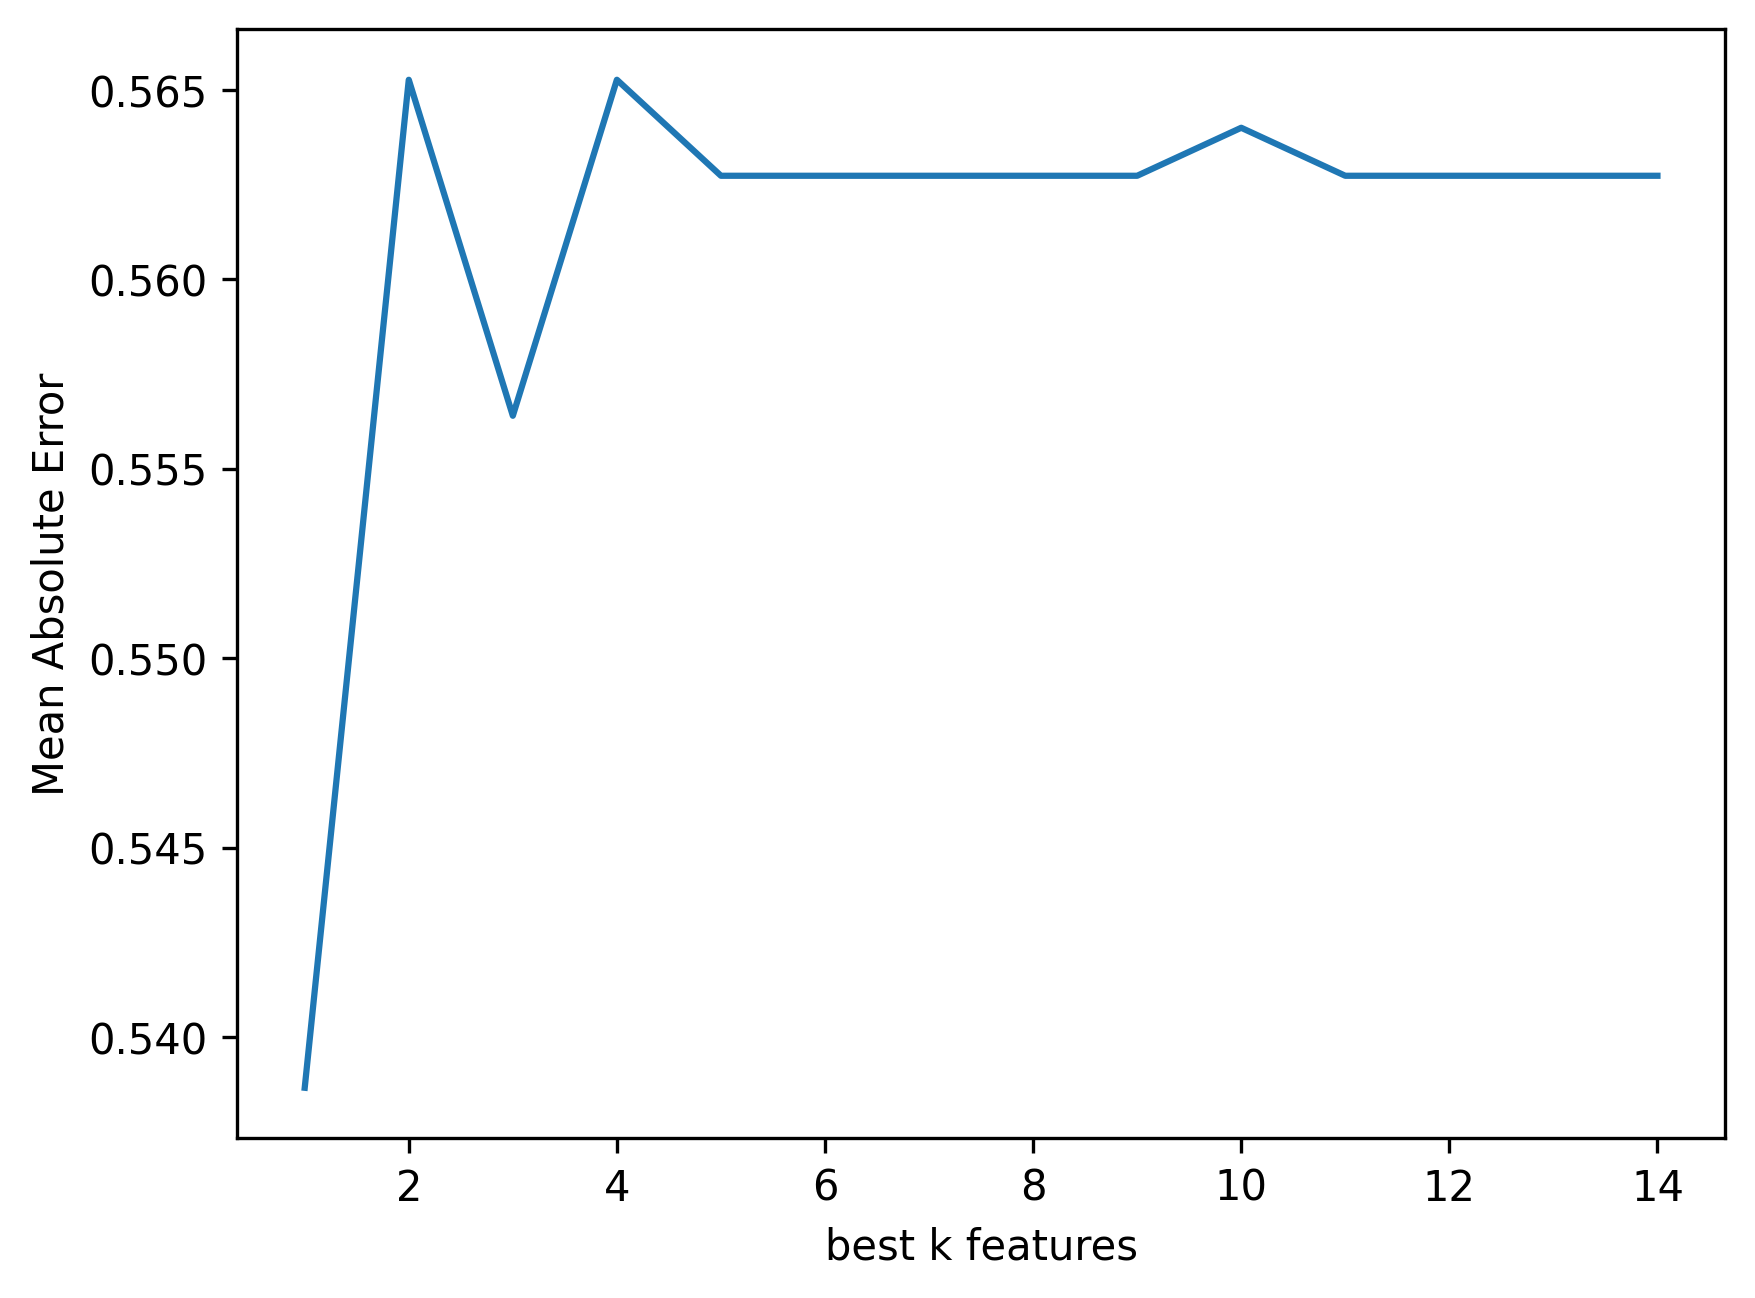

In [168]:
import sklearn.feature_selection as fs
model = SVC()
score_list = []
for k in range(1, 15):
    bk = fs.SelectKBest(score_func=fs.f_classif, k=k)
    bk.fit(X, Y)
    X_trans = bk.transform(X)
    train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                        Y,
                                                        test_size=0.2,
                                                        random_state=42)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    score = metrics.accuracy_score(test_y, y_pred)
    score_list.append(score)

fig, axe = plt.subplots(dpi = 300)
axe.plot(range(1, 15), score_list)
axe.set_xlabel("best k features")
axe.set_ylabel("Mean Absolute Error")
#fig.savefig("output/img.png")
#plt.close(fig)

In [169]:
import sklearn.feature_selection as fs
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier()
rf.fit(X, Y)
print("The feature importances of RandomForest")
print(rf.feature_importances_)

model = fs.SelectFromModel(rf, prefit=True)
X_trans = model.transform(X)
print("The shape of original data is {}".format(X.shape))
print("The shape of transformed data is {}".format(X_trans.shape))

The feature importances of RandomForest
[0.01722481 0.01682984 0.01906502 0.01647751 0.01795549 0.01963505
 0.01835273 0.02322748 0.01897605 0.02943255 0.02120787 0.02181916
 0.02781836 0.02120803 0.01808662 0.01788569 0.01920061 0.02166599
 0.01770531 0.02628348 0.01894233 0.02361689 0.01817698 0.02120615
 0.02077069 0.01950259 0.02283129 0.02152598 0.01744447 0.02133669
 0.01949433 0.01807654 0.0206633  0.01978734 0.01833852 0.02551914
 0.02340085 0.02545848 0.02301779 0.02346785 0.03012224 0.02173617
 0.02154756 0.01945769 0.02105037 0.03036516 0.02308498]
The shape of original data is (3944, 47)
The shape of transformed data is (3944, 20)


In [146]:
def get_score_after_permutation(model, X, Y, curr_feat):
    """return the score of model when curr_feat is permuted"""

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values
    )

    permuted_score = model.score(X_permuted, Y)
    return permuted_score


def get_feature_importance(model, X, Y, curr_feat):
    """compare the score when curr_feat is permuted"""

    baseline_score_train = model.score(X, Y)
    permuted_score_train = get_score_after_permutation(model, X, Y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

In [171]:
def permutation_importance(model, X, Y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, Y, curr_feat)
            )

        importances.append(list_feature_importance)

    return {
        "importances_mean": np.mean(importances, axis=1),
        "importances_std": np.std(importances, axis=1),
        "importances": importances,
    }


# This function could directly be access from sklearn
# from sklearn.inspection import permutation_importance
def plot_feature_importances(perm_importance_result, feat_name):
    """bar plot the feature importance"""

    fig, ax = plt.subplots()
    plt.figure(figsize=(30,30))

    indices = perm_importance_result["importances_mean"].argsort()
    plt.barh(
        range(len(indices)),
        perm_importance_result["importances_mean"][indices],
        xerr=perm_importance_result["importances_std"][indices],
    )

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

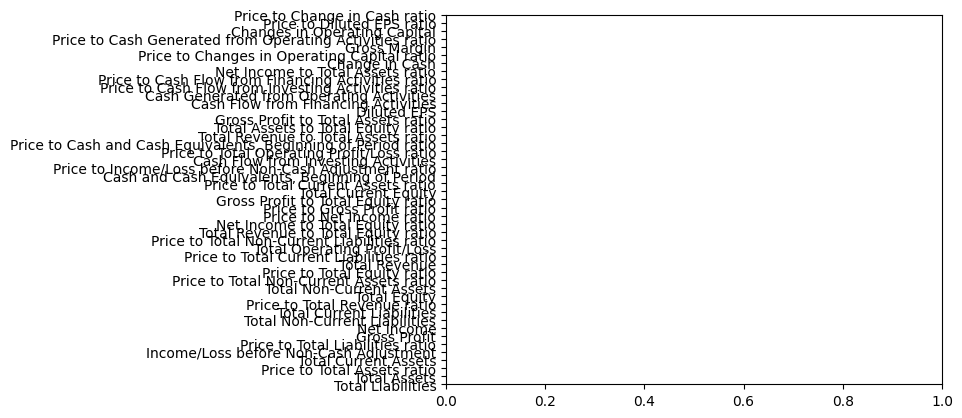

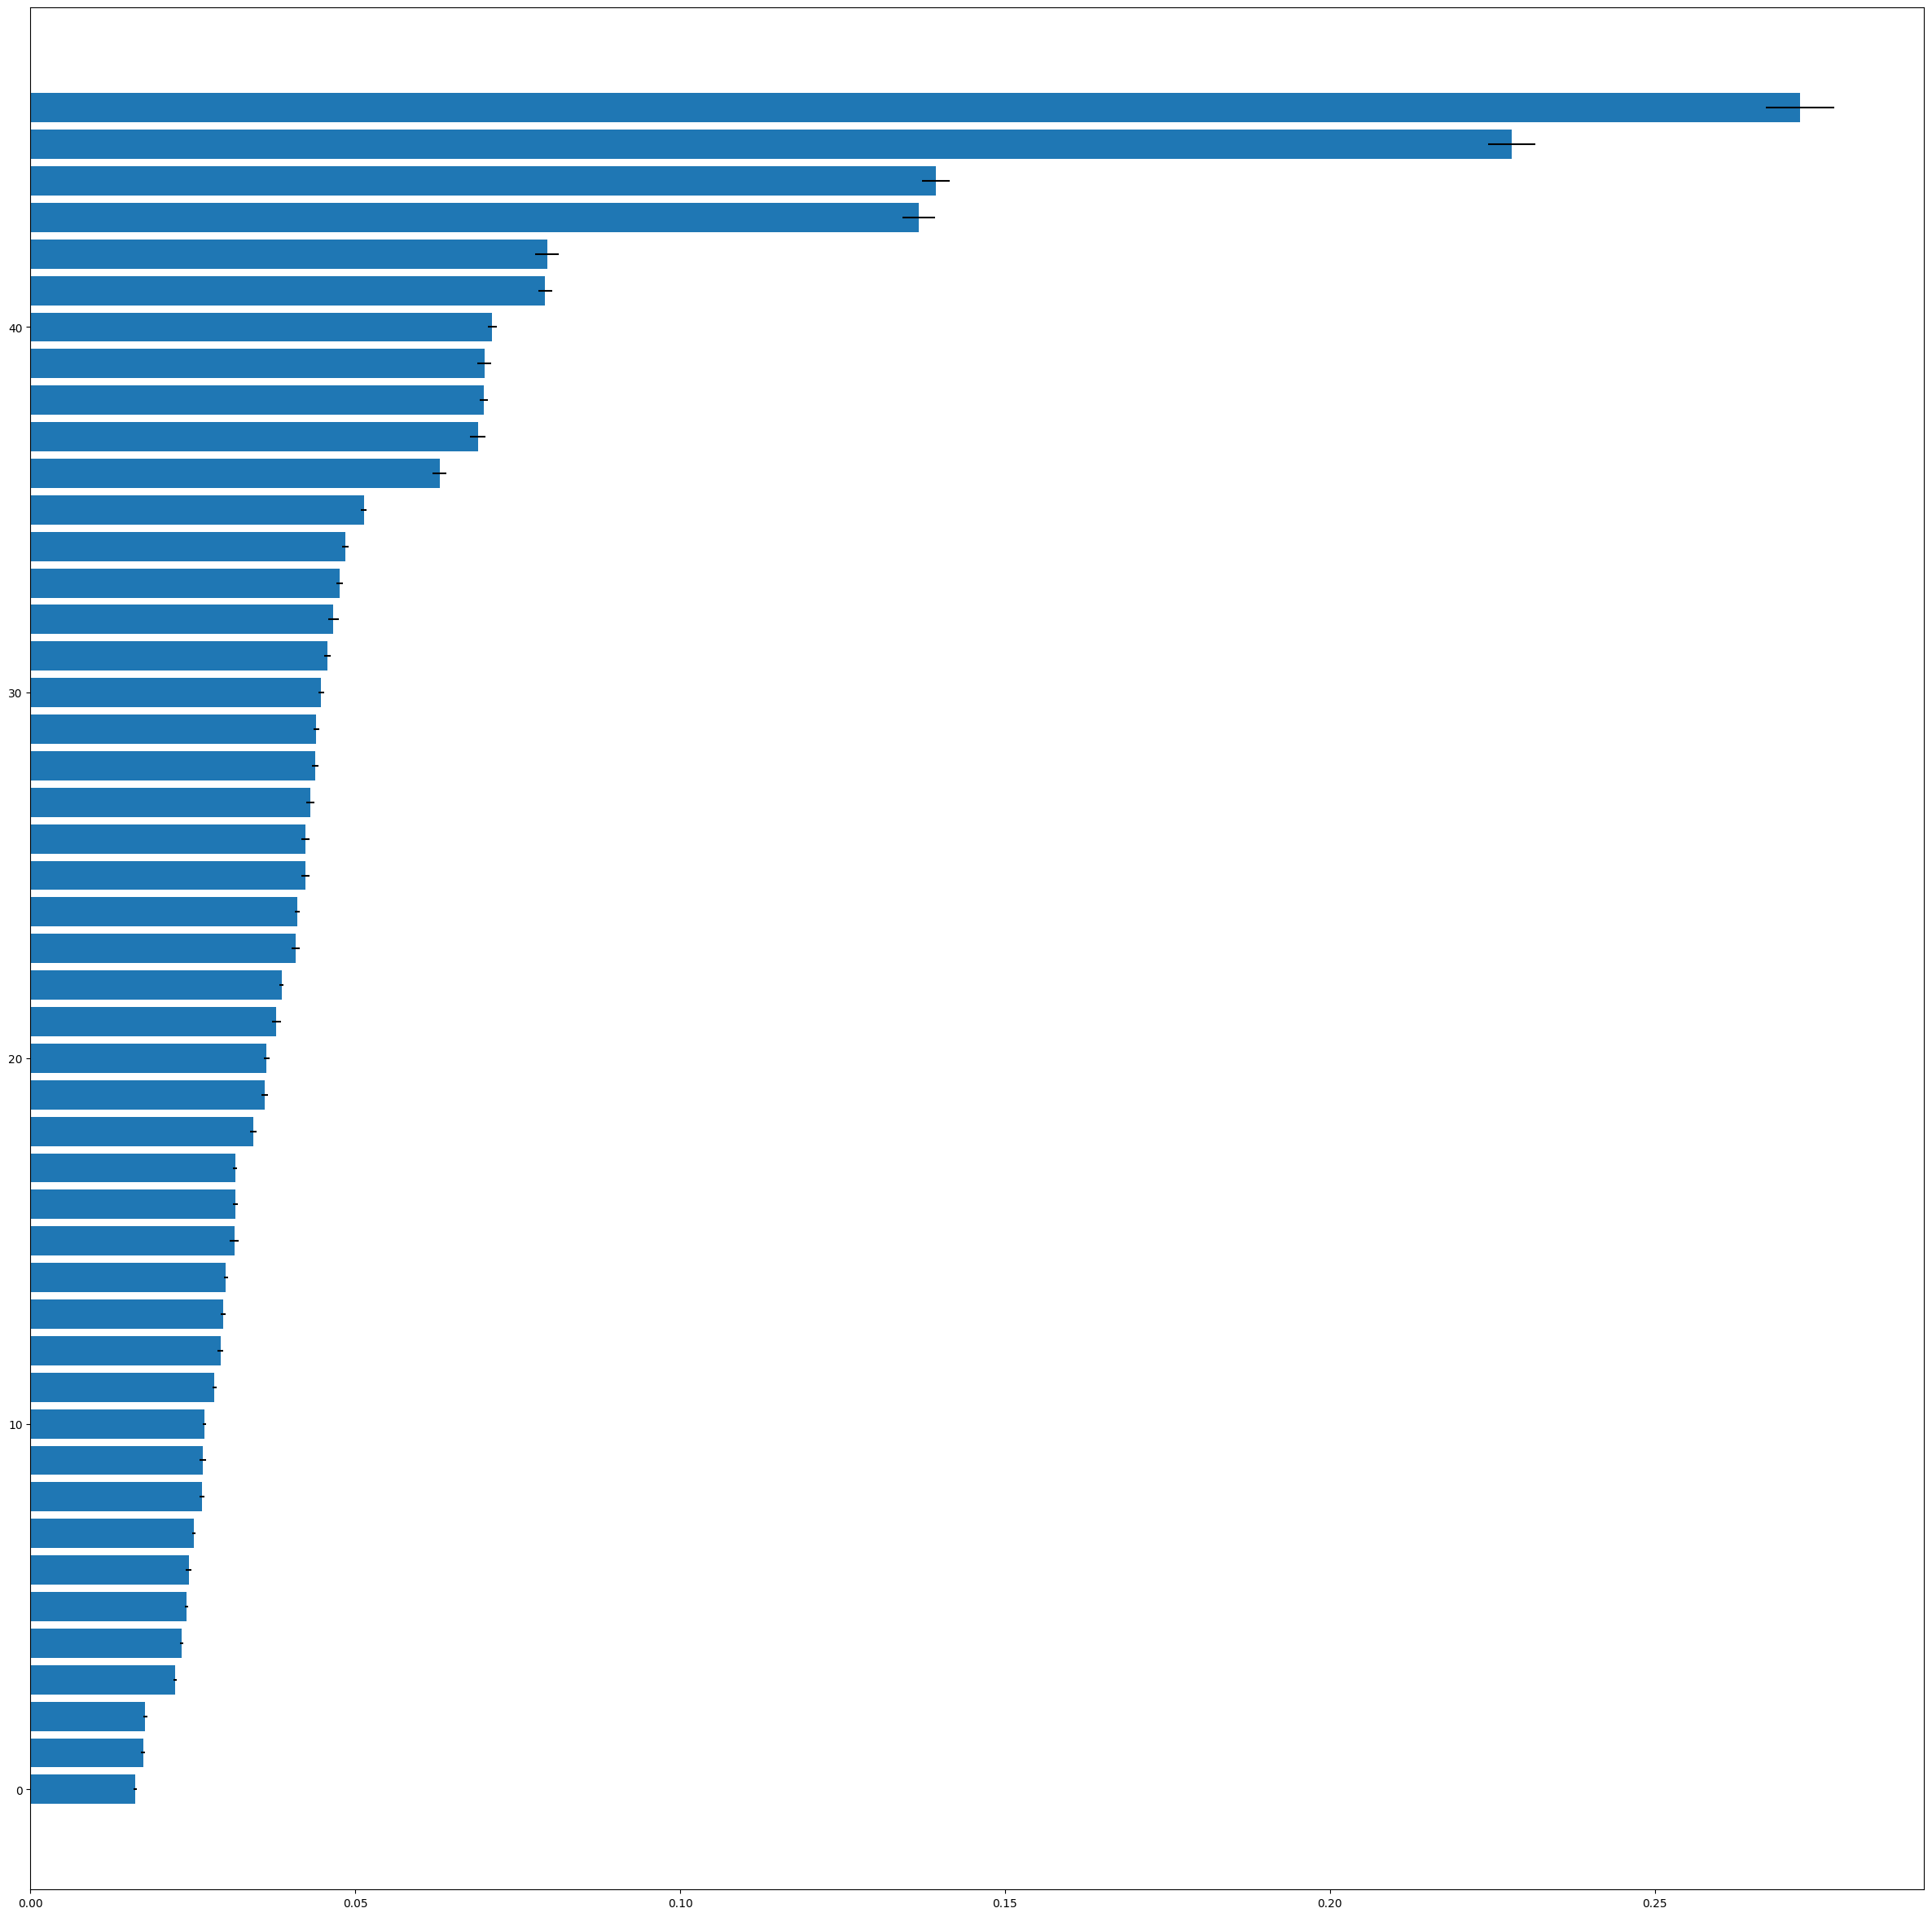

In [172]:
model = RandomForestRegressor()
model.fit(X,Y)

perm_importance_result_train = permutation_importance(
    model, X, Y, n_repeats=10
)

plot_feature_importances(perm_importance_result_train, X.columns)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model,
    X,
    Y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [model[1].coef_ for model in cv_model["estimator"]],
    columns=X_with_rnd_feat.columns,
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [173]:
common_features_selected = list(set(selected_feature_names).intersection(list_of_selected_features))
print(common_features_selected)
X_selected = X[list_of_selected_features]

['Cash Flow from Financing Activities', 'Gross Profit to Total Assets ratio', 'Price to Cash Flow from Financing Activities ratio', 'Gross Margin', 'Price to Diluted EPS ratio', 'Price to Income/Loss before Non-Cash Adjustment ratio', 'Price to Changes in Operating Capital ratio', 'Net Income to Total Assets ratio', 'Gross Profit to Total Equity ratio']


In [98]:
X

Total Assets  Total Current Assets  Total Non-Current Assets  \
0      183670000.0           113239000.0                70431000.0   
1      273475000.0           153928000.0               119547000.0   
2      322318000.0           157552000.0               164766000.0   
3      452984000.0           229697000.0               223287000.0   
4      466840000.0           194275000.0               272565000.0   
...            ...                   ...                       ...   
3939   299424000.0           244920000.0                54504000.0   
3940   402227000.0           266784000.0               135443000.0   
3941   421507000.0           293740000.0               127767000.0   
3942   441252000.0           328335000.0               112917000.0   
3943   668598000.0           518552000.0               150046000.0   

      Total Liabilities  Total Current Liabilities  \
0            68658000.0                 48601000.0   
1           108077000.0                 74080000.0   
2            94934000.0                 59973000.0   
3           119708000.0                 70708000.0   
4           137746000.0                 77418000.0   
...                 ...                        ...   
3939        146431000.0                131853000.0   
3940        237568000.0                165620000.0   
3941        249594000.0                187997000.0   
3942        270645000.0                219297000.0   
3943        571438000.0                311619000.0   

      Total Non-Current Liabilities  Total Equity  \
0                        20057000.0   115012000.0   
1                        33997000.0   165398000.0   
2                        34961000.0   227384000.0   
3                        49000000.0   333276000.0   
4                        60328000.0   329094000.0   
...                             ...           ...   
3939                     14578000.0   152993000.0   
3940                     71948000.0   164659000.0   
3941                     61597000.0   171913000.0   
3942                     51348000.0   170607000.0   
3943                    259819000.0    97160000.0   

      Cash Generated from Operating Activities  \
0                                    7242000.0   
1                                  -15212000.0   
2                                   57104000.0   
3                                   84284000.0   
4                                   14029000.0   
...                                        ...   
3939                               -23581000.0   
3940                                -3590000.0   
3941                                11286000.0   
3942                                18686000.0   
3943                               -20644000.0   

      Income/Loss before Non-Cash Adjustment  Changes in Operating Capital  \
0                                  4283000.0                    -6224000.0   
1                                 10793000.0                   -42921000.0   
2                                 31234000.0                    16379000.0   
3                                 73951000.0                   -20022000.0   
4                                 -2146000.0                   -22346000.0   
...                                      ...                           ...   
3939                             -77590000.0                    15328000.0   
3940                             -83394000.0                     -737000.0   
3941                             -73174000.0                   -15556000.0   
3942                             -99425000.0                   -14270000.0   
3943                            -197970000.0                    37735000.0   

      ...  Price to Changes in Operating Capital ratio  \
0     ...                                -4.182796e+05   
1     ...                                -3.805053e+06   
2     ...                                 9.657430e+05   
3     ...                                -8.444539e+05   
4     ...                                -5.911640e

In [174]:
from sklearn.tree import DecisionTreeClassifier


def compare_methods(withSelection=False,withScale=False):

    if withScale:
        x = X_scaled

    elif withSelection:
        x = X_selected

    else:
        x = X
    print(x.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=1, shuffle=True)
    
    models = []

    models.append(("LogisticRegression", LogisticRegression()))
    models.append(("DecisionTree", DecisionTreeClassifier()))
    models.append(("SVR", SVC()))
    models.append(("RandomForest", RandomForestClassifier()))
    # models.append(("RidgeRegression", Lasso()))
    # models.append(("LassoRegression", Ridge()))

    train_times = []
    test_times = []
    results = []
    names = []

    for name, model in models:
        if model is not None:
            result = cross_val_score(model, x, Y, cv=6, scoring='accuracy')
            results.append(result)
        start_time = time.time()
        model.fit(x_train, y_train)
        train_time = time.time() - start_time
        if name == "SVR":
            print("time: ", train_time)
        
        start_time = time.time()
        score = model.score(x_test, y_test)
        if name == "SVR":
            print("score: ", score)
        test_time = time.time() - start_time
        
        names.append(name)
        train_times.append(train_time)
        test_times.append(test_time)
        


    # Plotting
    plt.figure(figsize=(10, 10))
    plt.barh(names, train_times, color='blue', label='Training Time')
    plt.barh(names, test_times, color='red', label='Testing Time', alpha=0.5)
    plt.xlabel('Time (seconds)')
    if withScale:
        plt.title('Comparison of Training and Testing Times for Different Estimators (Scaled Data)')
    elif withSelection:
        plt.title('Comparison of Training and Testing Times for Different Estimators (Selected Features)')
    else:
        plt.title('Comparison of Training and Testing Times for Different Estimators')
    plt.legend()
    plt.show()

    means = []
    for i in range(len(names)):
        means.append(results[i].mean())
    plt.figure(figsize=(10, 10))
    plt.bar(names, means)
    if withScale:
        plt.title("Performance comparison (nmse) [Scaled Data]")
    elif withSelection:
        plt.title("Performance comparison (nmse) [Selected Features]")
    else:
        plt.title("Performance comparison (nmse)")
    

    plt.show()

(3944, 47)
time:  0.5151207447052002
score:  0.5449936628643853


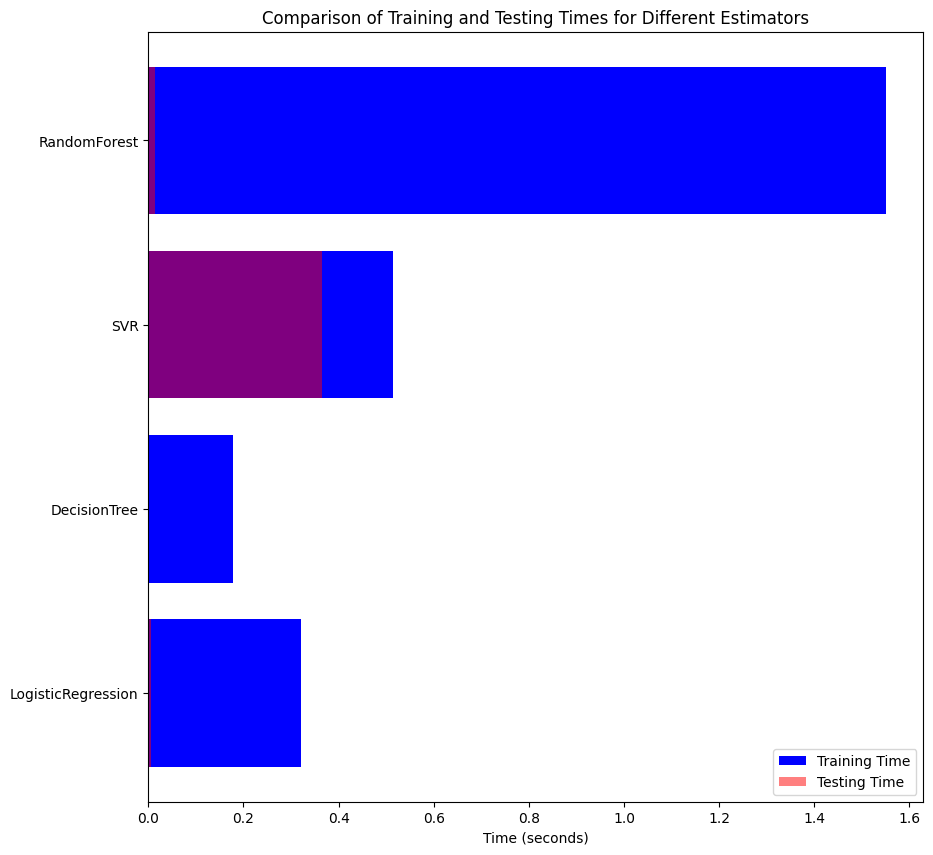

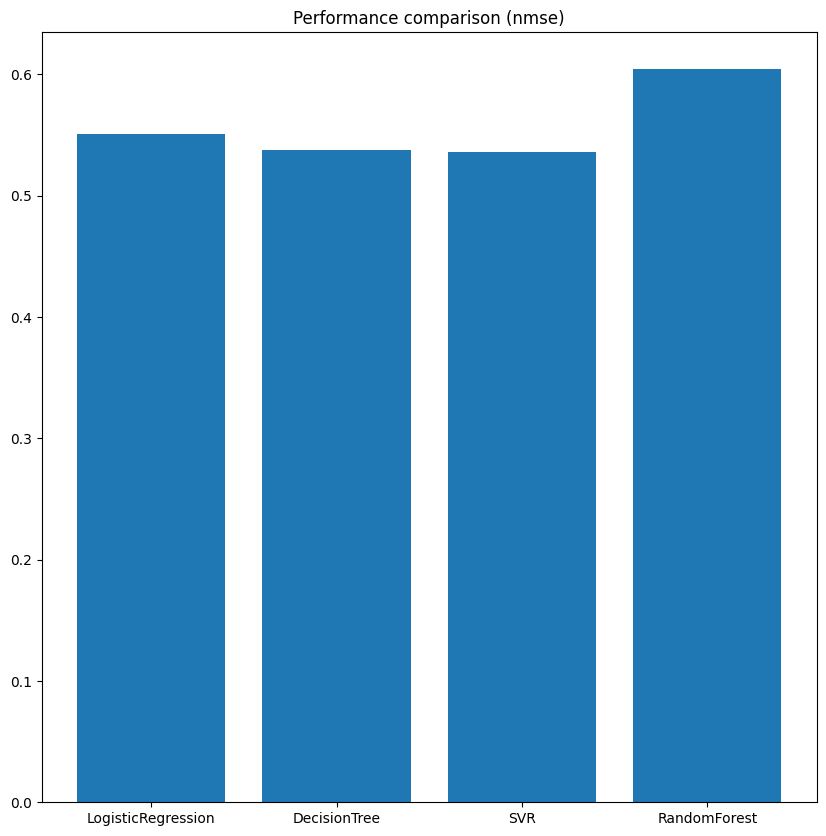

In [175]:
compare_methods(False,False)

(3944, 17)
time:  0.4318699836730957
score:  0.5462610899873257


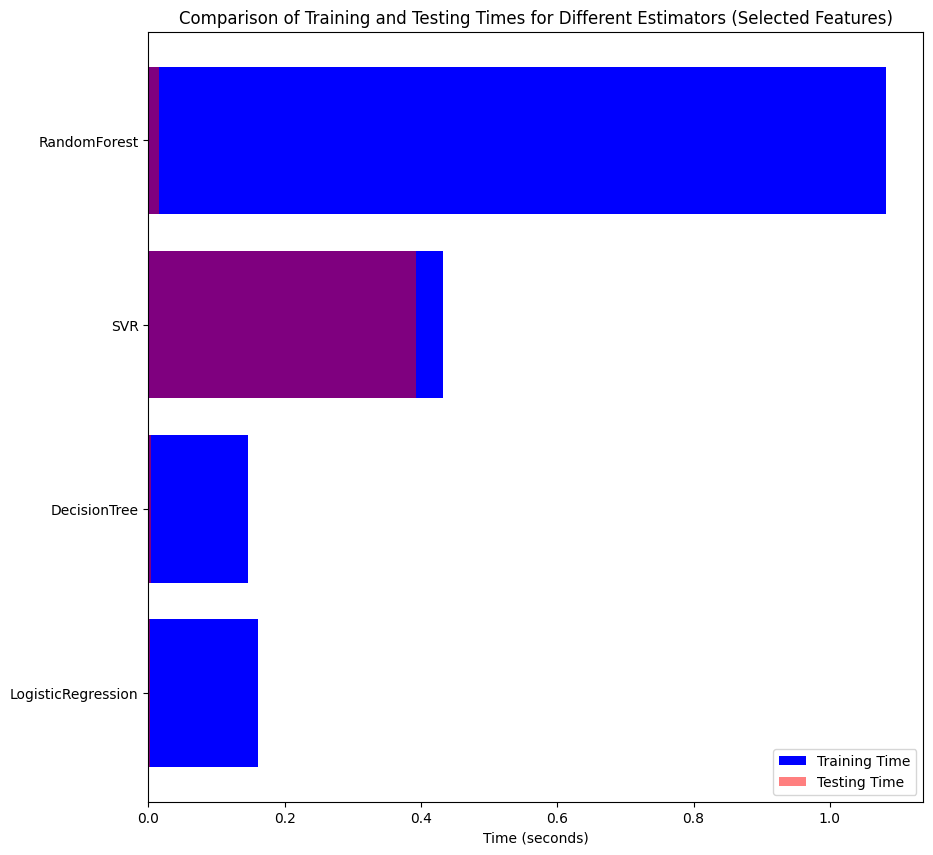

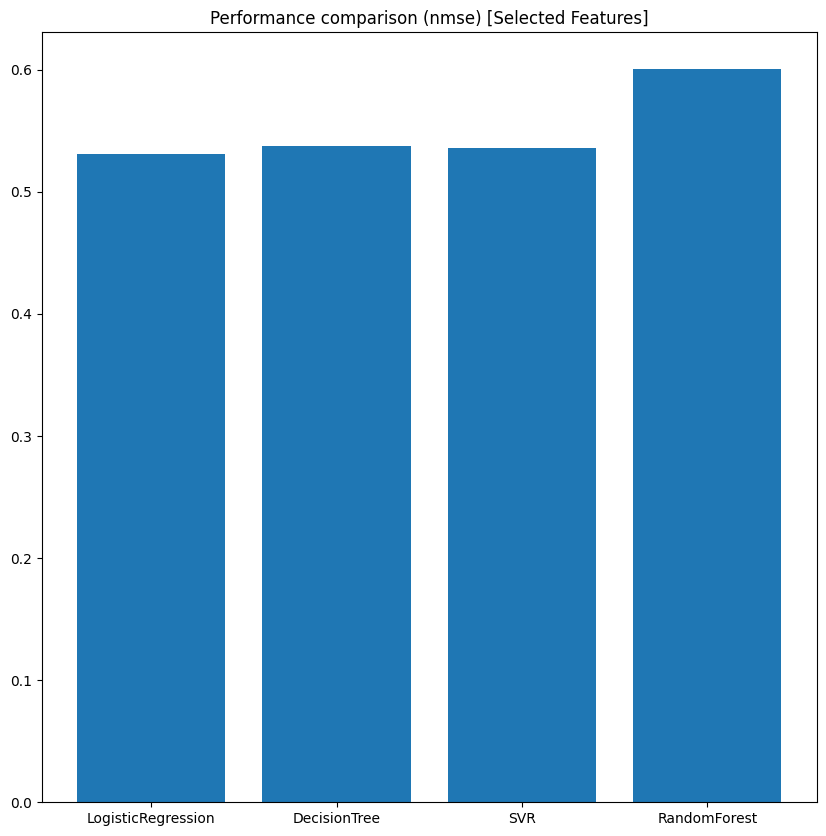

In [178]:
compare_methods(withSelection=True)

(3944, 47)
time:  0.9500150680541992
score:  0.5475285171102662


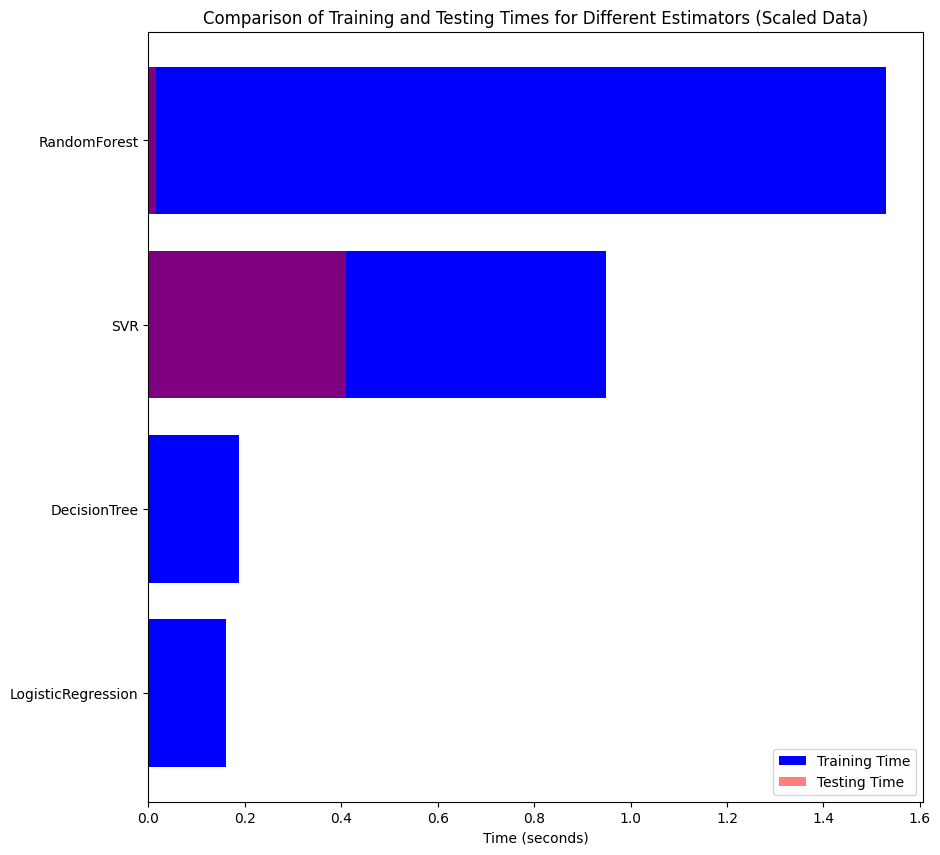

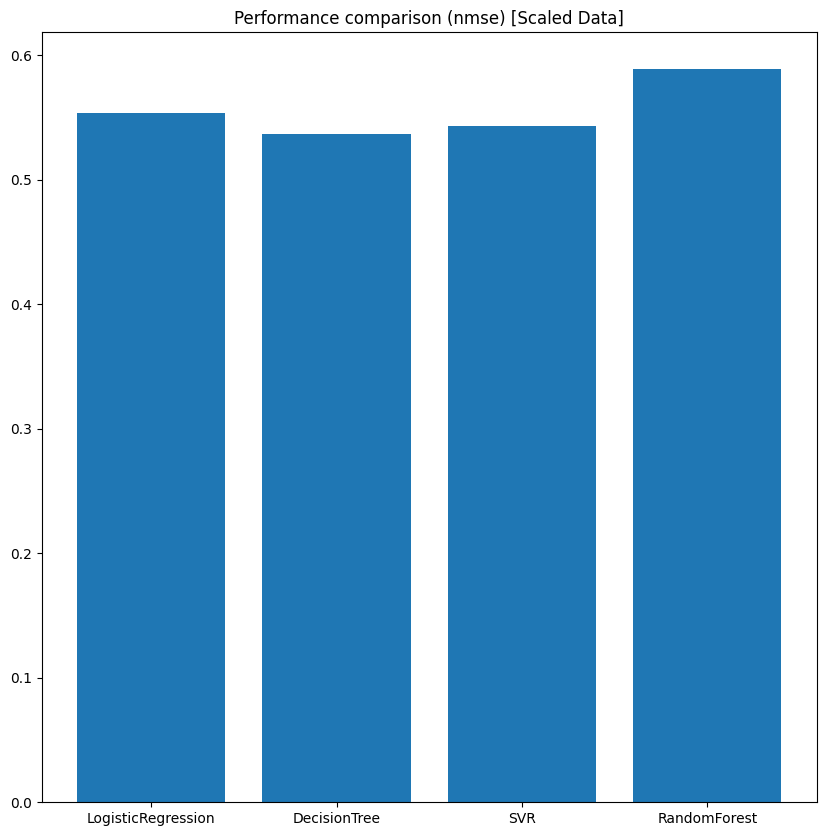

In [179]:
compare_methods(withScale=True)

In [69]:
import seaborn as sns
# Calculate Pearson correlation matrix
corr_matrix = dataset.corr()
corr_matrix_filtered = corr_matrix.abs() > 0.5
corr_matrix_filtered = corr_matrix[corr_matrix_filtered]
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Pearson Correlation between Features')
plt.show()


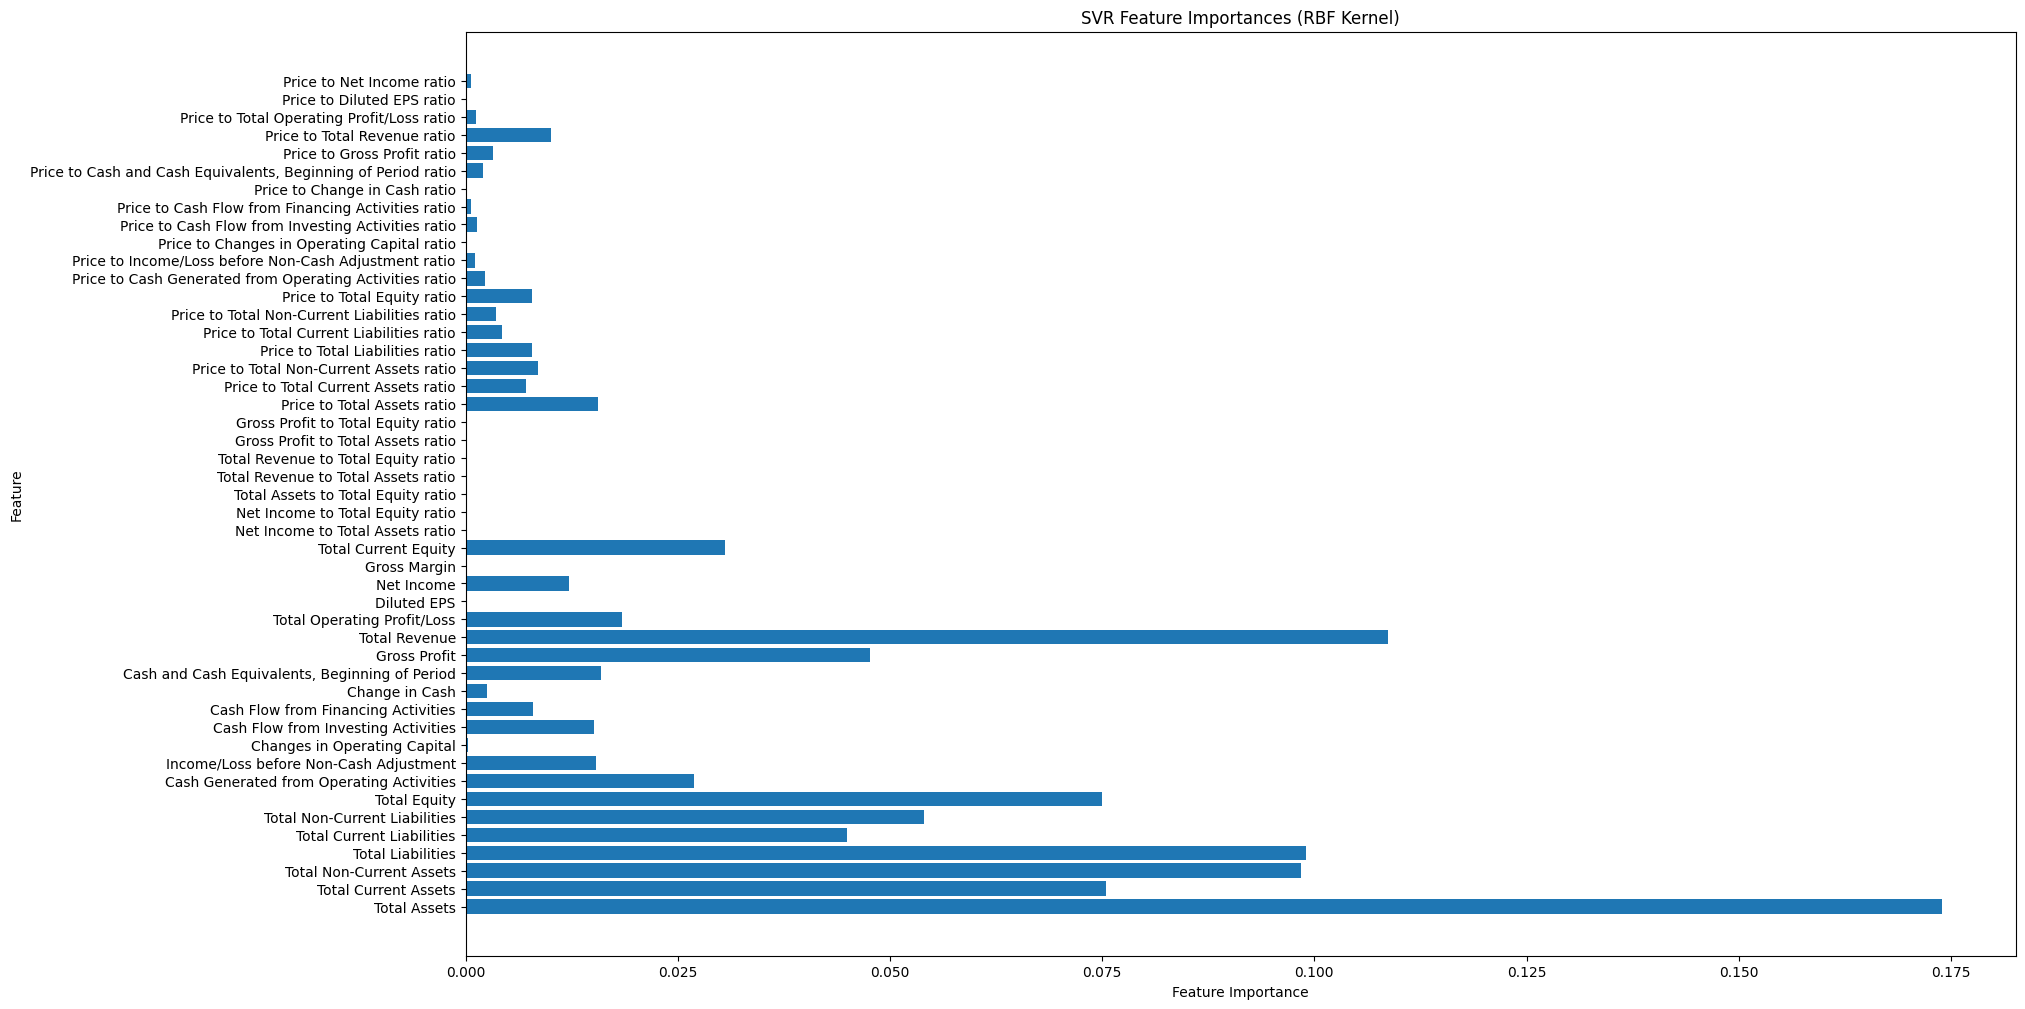

In [180]:


# Fit SVR model
svr = SVC()
svr.fit(X, Y)

# Compute distances from the decision boundary (the hyperplane)
distances = svr.predict(X) - Y

# Calculate importance scores for each feature based on distances from the decision boundary
feature_importances = np.abs(np.dot(X.T, distances))

# Normalize feature importances
feature_importances /= feature_importances.sum()

# Plot feature importances
plt.figure(figsize=(20, 12))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(feature_importances)), dataset.columns.to_list()[:-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('SVR Feature Importances (RBF Kernel)')
plt.show()


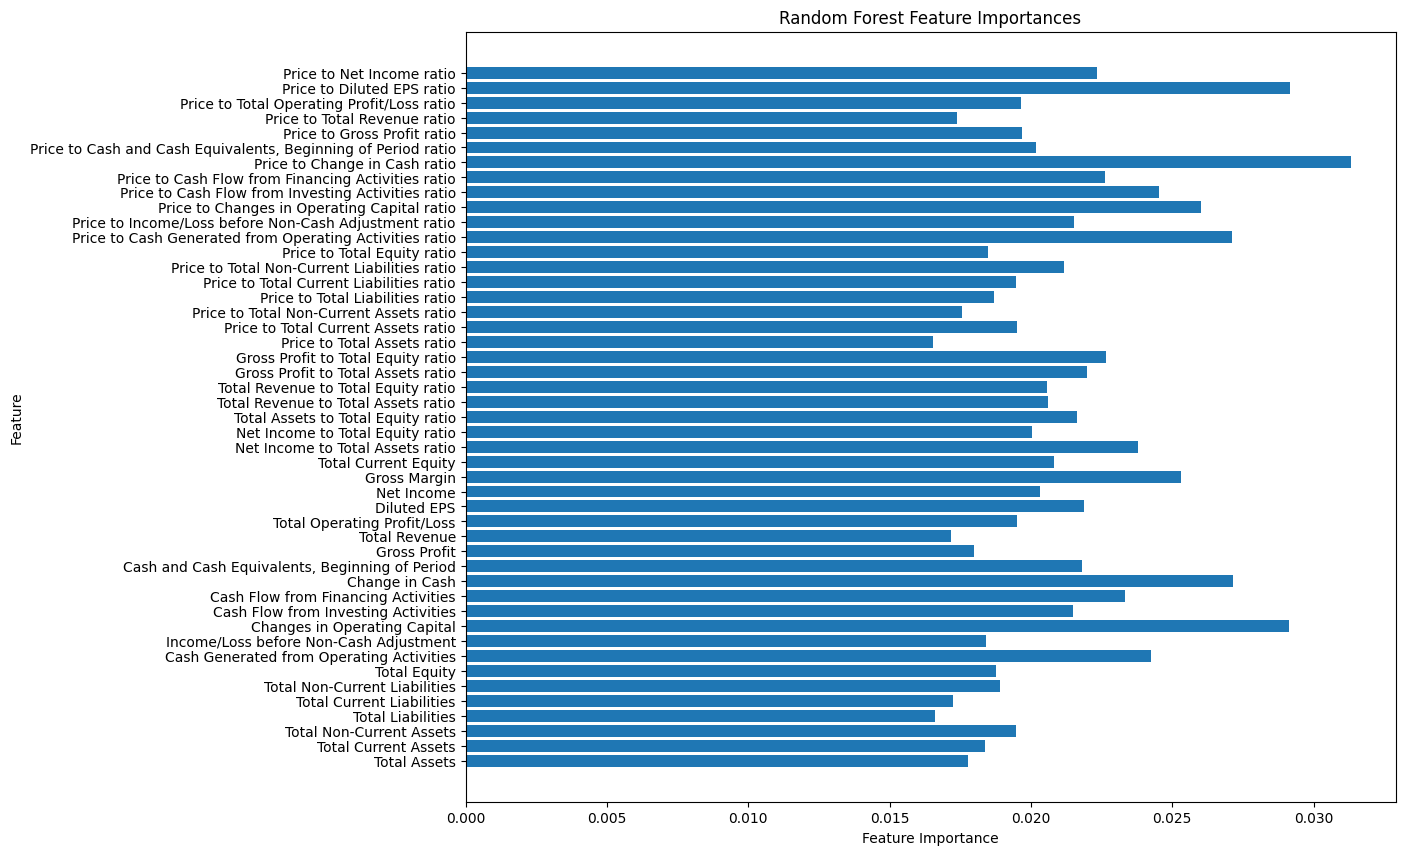

In [185]:

feature_names = [f'Feature_{i}' for i in range(X.shape[1])]  # Replace this with your actual column names

# Fit Random Forest model
rf = RandomForestClassifier()
rf.fit(X, Y)

# Get feature importances
feature_importances = rf.feature_importances_

plt.figure(figsize=(12, 10))
plt.barh(dataset.columns.to_list()[:-1], feature_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()
